# Прогнозирование вероятности дефолта заемщика

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc, roc_auc_score, roc_curve, mean_squared_error, precision_score
from sklearn.metrics import recall_score, f1_score, accuracy_score, classification_report, precision_recall_fscore_support, r2_score, mean_absolute_error


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from xgboost import XGBClassifier

# Описания полей

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

# Загрузка данных

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
print(df_train.info())
print('Train size: ', df_train.shape)
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [4]:
print(df_test.info())
print('Test size: ', df_test.shape)
df_test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


Видим, что в поле education имеются незаполненные значения

Объединим тестовые и тренировочные данные в один датафрейм, чтобы упростить обработку данных

In [5]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['default'] = -1
df = df_train.append(df_test, sort=False).reset_index(drop=True)

C:\Users\shadee\AppData\Local\Temp\ipykernel_7044\3204142804.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_train.append(df_test, sort=False).reset_index(drop=True)


In [6]:
df['education'].isna().sum()

478

Так как их количество не слишком велико, заменим null значения на самое популярное

In [7]:
df['education'].nunique()

5

In [8]:
df['education'].unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', nan], dtype=object)

<AxesSubplot:>

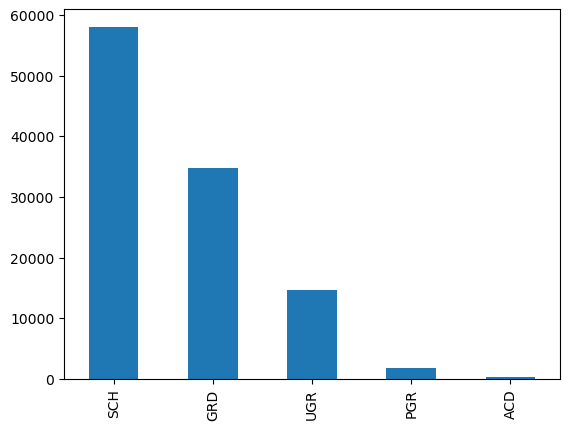

In [9]:
df['education'].value_counts().plot.bar()

In [10]:
df.education = df_train.education.fillna("SCH")

In [11]:
print(df.info())
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         73799 non-null   object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

(110148, 20)

# Разведочный анализ данных (РАД, EDA)

In [12]:
num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','region_rating'] 
cat_cols = ['education','work_address','home_address','sna','first_time'] 
bin_cols = ['sex','car','car_type','good_work','foreign_passport'] 

In [13]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,sample
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,-0.244916,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.595908,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,-1.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,-1.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


<AxesSubplot:>

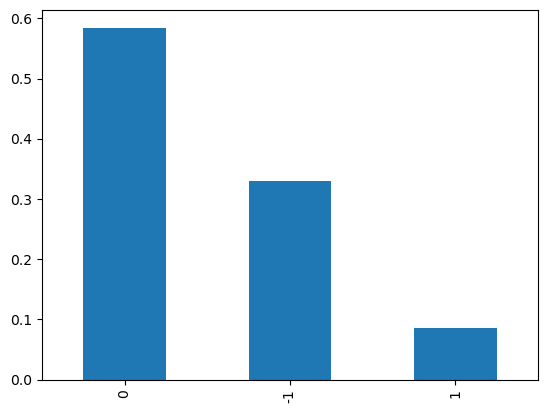

In [14]:
df['default'].value_counts(normalize=True).plot.bar()

array([[<AxesSubplot:title={'center':'client_id'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'decline_app_cnt'}>,
        <AxesSubplot:title={'center':'good_work'}>],
       [<AxesSubplot:title={'center':'score_bki'}>,
        <AxesSubplot:title={'center':'bki_request_cnt'}>,
        <AxesSubplot:title={'center':'region_rating'}>,
        <AxesSubplot:title={'center':'home_address'}>],
       [<AxesSubplot:title={'center':'work_address'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'sna'}>,
        <AxesSubplot:title={'center':'first_time'}>],
       [<AxesSubplot:title={'center':'default'}>,
        <AxesSubplot:title={'center':'sample'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

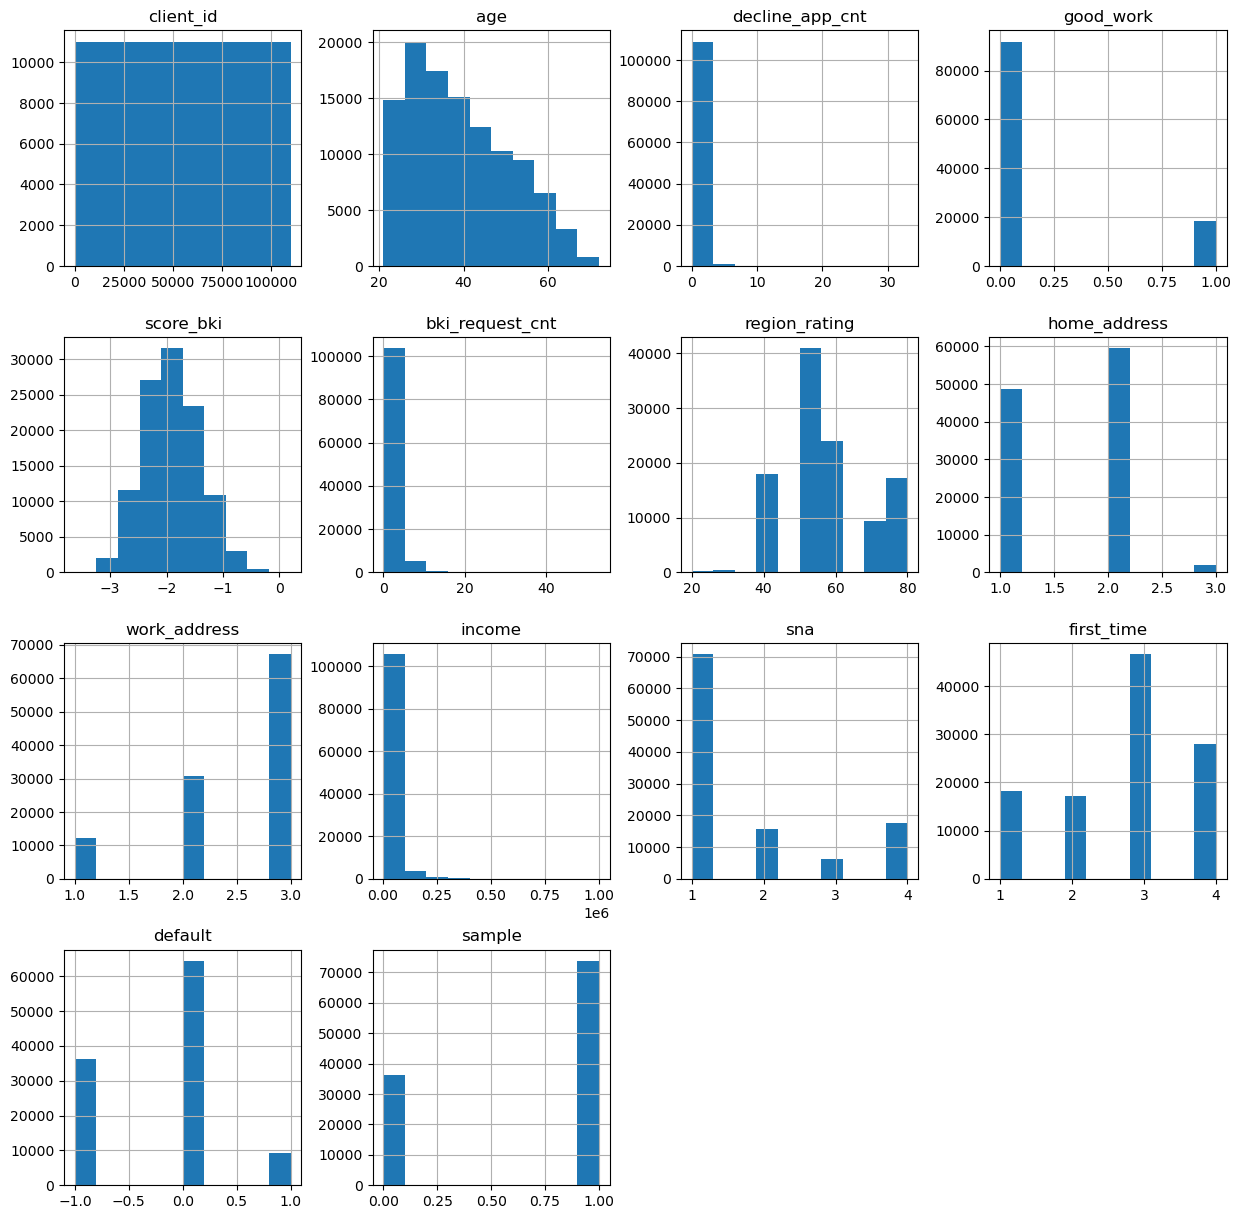

In [15]:
df.hist(figsize=(15,15))

По данным графикам видно, что:

1) Большинство клиентов банка возрастом <50

2) Очень редко встречаются клиенты с большим количеством отказанных заявок

3) Только 25% клиентов имеют хорошую работу

4) Распределение score_bki близко к нормальному

5) Категория рабочего адреса клиента чаще выше домашнего

6) Большинство клиентов не имеют машину, но среди владельцев автомобилей многие имеют иномарки

7) Большинство клиентов не имеют загранпаспорт

Логарифмируем признаки, на которых виден сдвиг влево

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


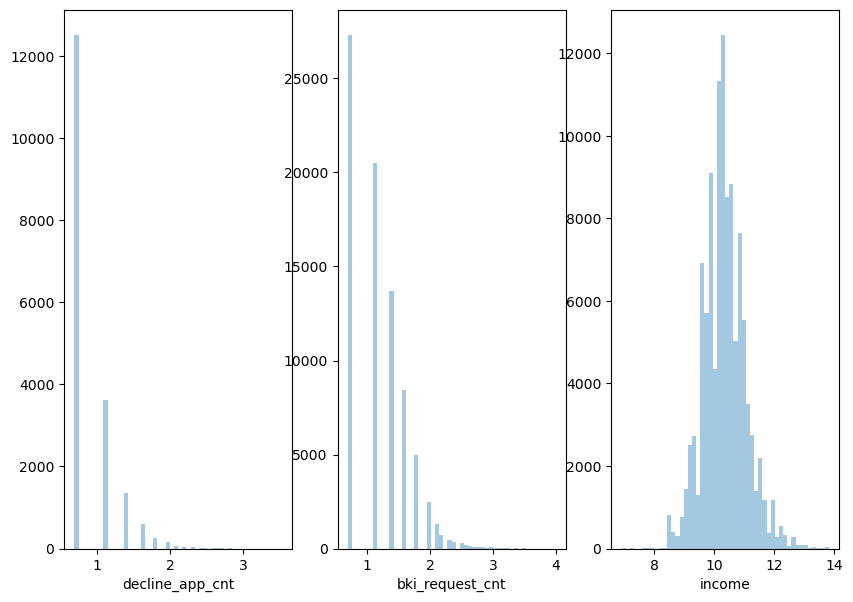

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(10,7))
for i,col in enumerate(['decline_app_cnt', 'bki_request_cnt', 'income']):
    df[col] = np.log(df[col] + 1)
    sns.distplot(df[col][df[col] > 0].dropna(), ax=axes.flat[i],kde = False, rug=False)
    

# Численные

<AxesSubplot:xlabel='age', ylabel='income'>

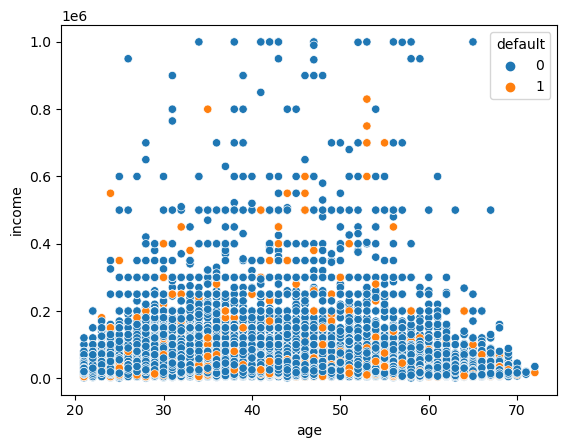

In [17]:
sns.scatterplot(data=df_train, x="age", y = "income", hue= "default")

Клиенты старше 60 и меньше 25 зарабатывают немного меньше, но в остальном между возрастом 
и заработком нет сильной связи.

<AxesSubplot:xlabel='score_bki', ylabel='income'>

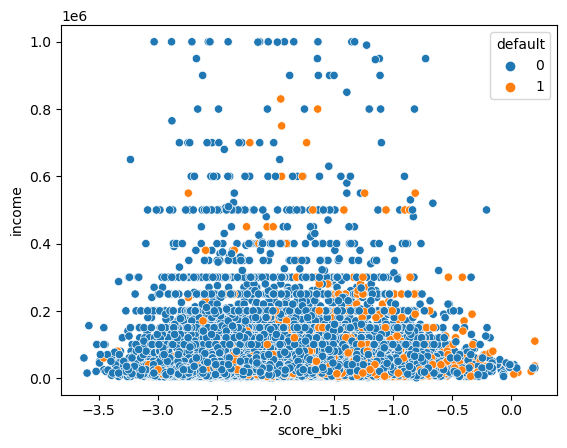

In [18]:
sns.scatterplot(data=df_train, x = "score_bki", y = "income", hue= "default")

Здесь наглядно видно, что у клиентов с плохим кредитным рейтингом чаще случаи дефолта, так же
можно увидеть, что у клиентов с очень высоким заработком почти не встречаются случаи дефолта. 

<AxesSubplot:xlabel='decline_app_cnt', ylabel='income'>

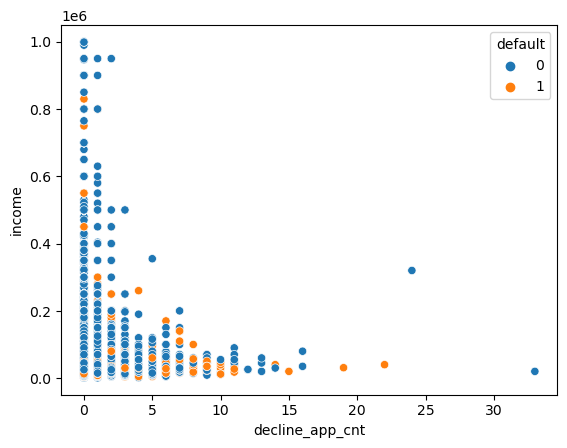

In [19]:
sns.scatterplot(data=df_train, x="decline_app_cnt", y = "income", hue= "default")

Так же видим, что в среднем, чем больше у клиента отказанных заявок, тем вероятнее дефолт,
за исключением двух случаев, можем предположить что банк крайне обудманно
выдавал кредит таким клиентам.

# *Категориальные*

Рассмотрим зависимость дохода от уровня образования

<AxesSubplot:xlabel='education', ylabel='income'>

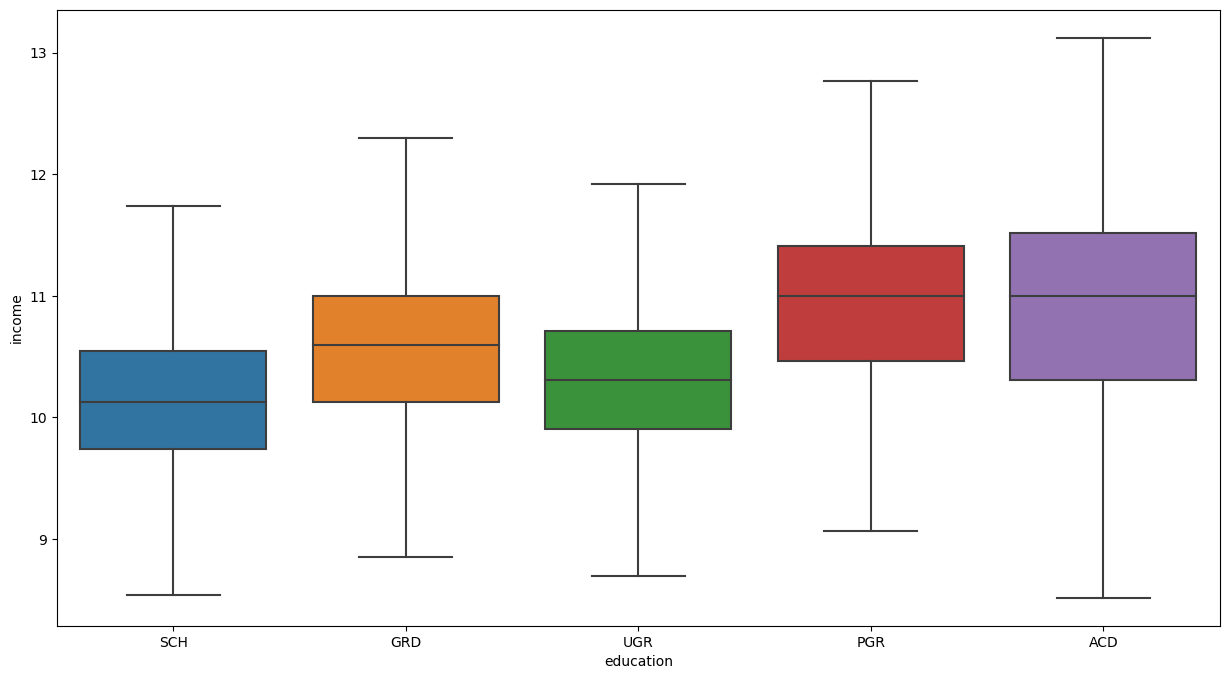

In [20]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="education", y="income", data=df, showfliers=False)

<AxesSubplot:xlabel='home_address', ylabel='count'>

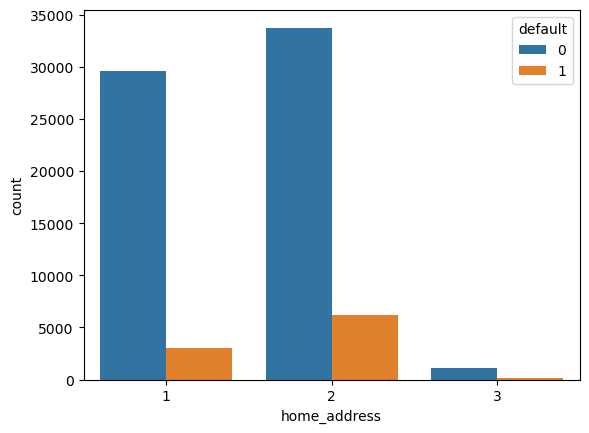

In [21]:
sns.countplot(data=df_train, x='home_address', hue='default')

<AxesSubplot:xlabel='work_address', ylabel='count'>

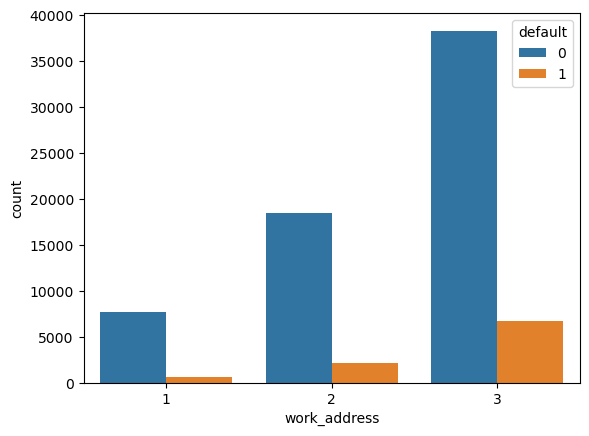

In [22]:
sns.countplot(data=df_train, x='work_address', hue='default')

# Бинарные

<AxesSubplot:xlabel='car', ylabel='count'>

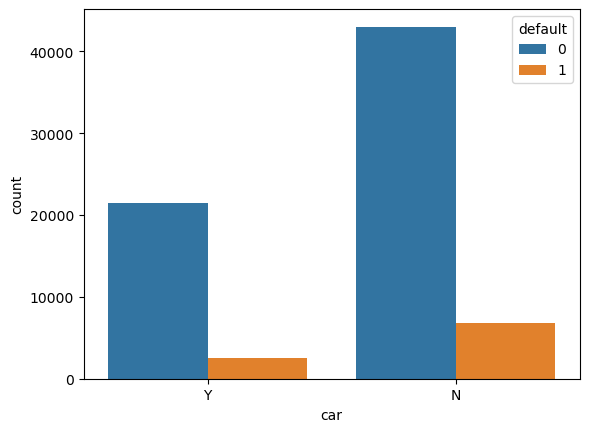

In [23]:
sns.countplot(data=df_train, x='car', hue='default')

<AxesSubplot:xlabel='good_work', ylabel='count'>

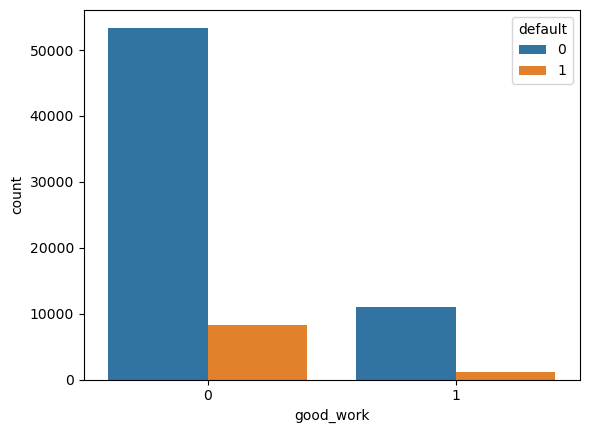

In [24]:
sns.countplot(data=df_train, x='good_work', hue='default')

У клиентов с хорошей работой малый шанс дефолта.

<AxesSubplot:xlabel='foreign_passport', ylabel='count'>

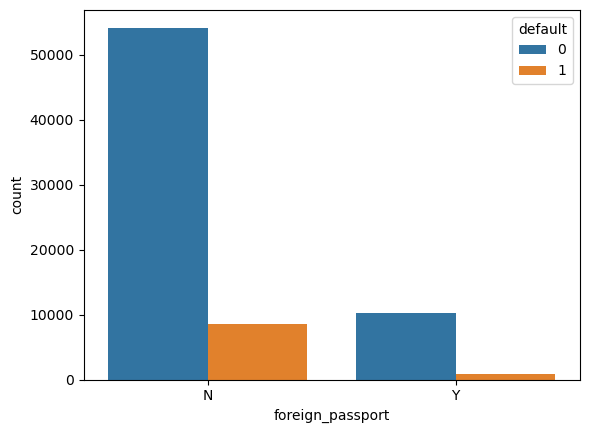

In [25]:
sns.countplot(data=df_train, x='foreign_passport', hue='default')

Так же почти не встречаются случаи дефолта у клиентов с загранпаспортом.

<AxesSubplot:xlabel='car_type', ylabel='count'>

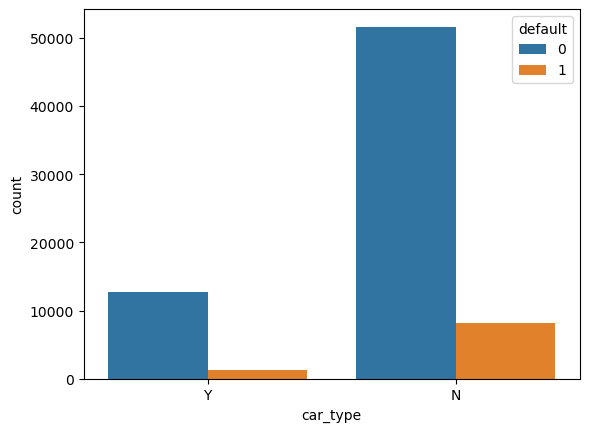

In [26]:
sns.countplot(data=df_train, x='car_type', hue='default')

<AxesSubplot:xlabel='sna', ylabel='count'>

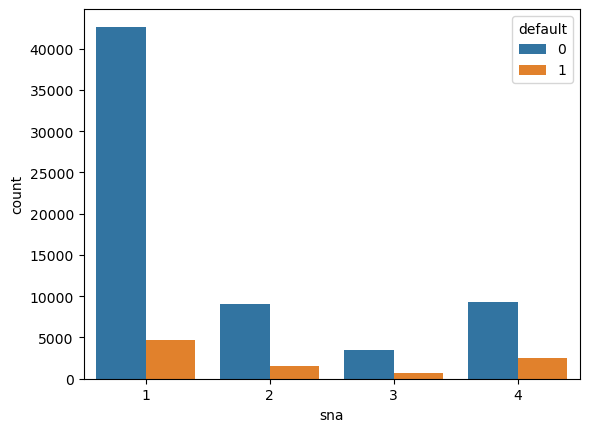

In [27]:
sns.countplot(data=df_train, x='sna', hue='default')

Введем дополнительный признак - категория машины:

0 - отсутствие машины

1 - отечественная машина 

2 - иностранная машина 

In [28]:
df_train['car_cat'] = df_train['car'] + df_train['car_type']
df_train['car_cat'] = df_train['car_cat'].astype('category')
df_train['car_cat'].replace('NN', 0, inplace=True)
df_train['car_cat'].replace('YN', 1, inplace=True)
df_train['car_cat'].replace('YY', 2, inplace=True)

<AxesSubplot:xlabel='car_cat', ylabel='count'>

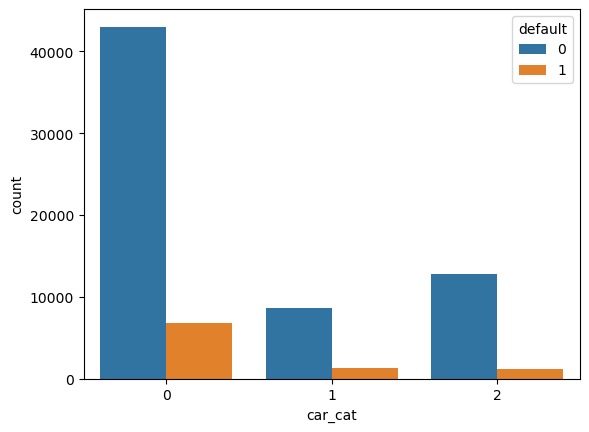

In [29]:
sns.countplot(data=df_train, x='car_cat', hue='default')

На удивление по этим данным наличие хорошей машины не сильно влияет на дефолт, важно именно ее наличие, и даже наоборот, у клиентов с отечественной машиной дефолт немного реже чем у владельцев иномарок.

<AxesSubplot:>

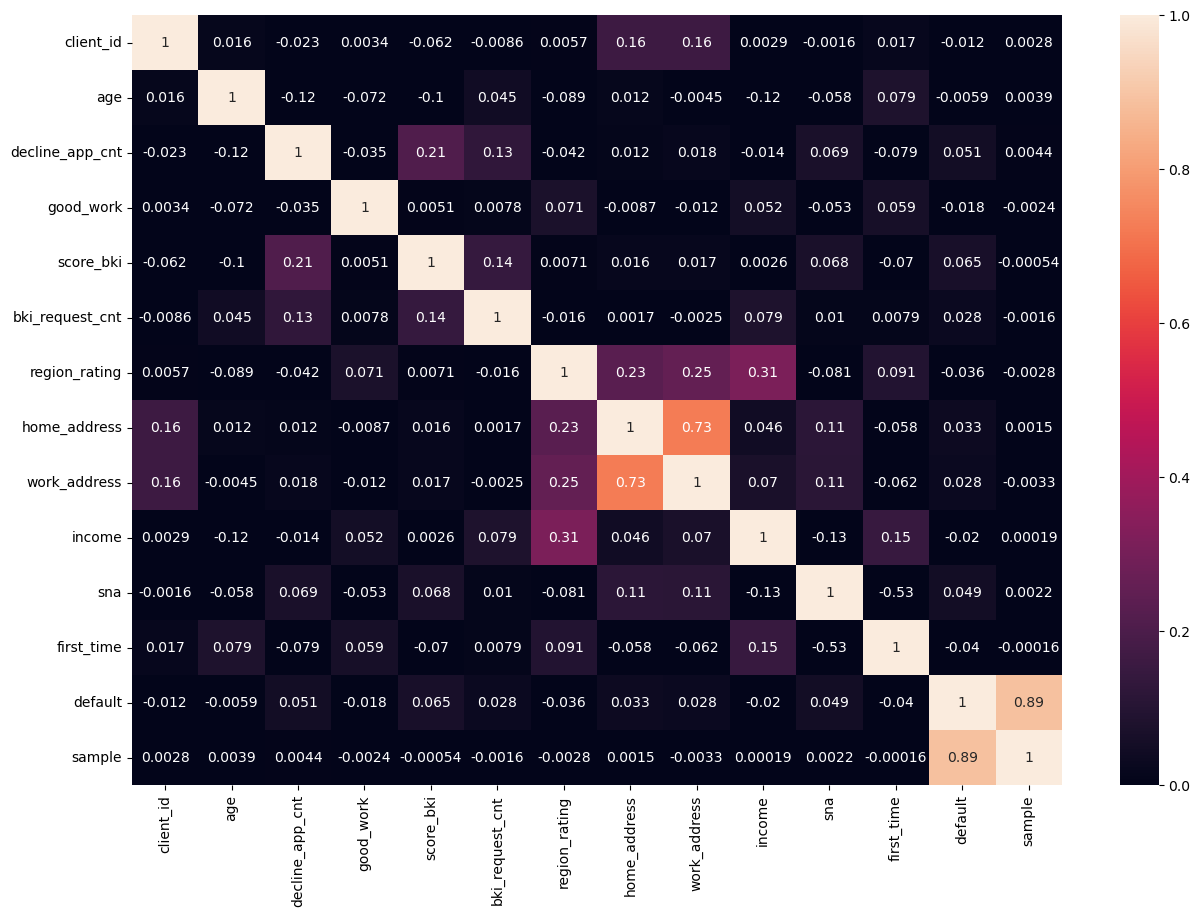

In [30]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.corr(), vmin=0, vmax=1, annot = True)

# Добавление признаков

Изменим значение даты, на кол-во дней с самой ранней в датафрейме

In [31]:
df['app_date'] = pd.to_datetime(df.app_date)
df['app_date'] = df['app_date'].apply(lambda x: (x - df['app_date'].min()).days)

In [32]:
df = df.copy()

Попробуем добавить еще новых признаков

In [33]:
# средний доход по возрасту
mean_income = df.groupby('age')['income'].mean().to_dict()
df['mean_income_age'] = df['age'].map(mean_income)

In [34]:
# максимальный доход по возрасту
max_income = df.groupby('age')['income'].max().to_dict()
df['max_income_age'] = df['age'].map(max_income)

In [35]:
# нормализованный доход по возрасту
df["normalized_income"] = abs((df.income - df.mean_income_age)/df.max_income_age)

In [36]:
# средние обращения по кредиту по возрасту
mean_bki = df.groupby('age')['bki_request_cnt'].mean().to_dict()
df['mean_requests_age'] = df['age'].map(mean_bki)

In [37]:
# средние обращения по кредиту по доходу
mean_bki_inc = df.groupby('income')['bki_request_cnt'].mean().to_dict()
df['mean_requests_income'] = df['income'].map(mean_bki_inc)

In [38]:
# средний доход по региону
mean_income_rat = df.groupby('region_rating')['income'].mean().to_dict()
df['mean_income_region'] = df['region_rating'].map(mean_income_rat)

# Кодирование данных

In [39]:
mapp = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    mapp[col] = dict(enumerate(label_encoder.classes_))

In [40]:
mappc = {}
enc = OneHotEncoder()
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])
    mappc[col] = dict(enumerate(label_encoder.classes_))

In [41]:
print(mapp)
print(mappc)

{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'good_work': {0: 0, 1: 1}, 'foreign_passport': {0: 'N', 1: 'Y'}}
{'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR', 5: nan}, 'work_address': {0: 1, 1: 2, 2: 3}, 'home_address': {0: 1, 1: 2, 2: 3}, 'sna': {0: 1, 1: 2, 2: 3, 3: 4}, 'first_time': {0: 1, 1: 2, 2: 3, 3: 4}}


In [42]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'sample',
       'mean_income_age', 'max_income_age', 'normalized_income',
       'mean_requests_age', 'mean_requests_income', 'mean_income_region'],
      dtype='object')

In [43]:
num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','app_date', 'mean_income_age','region_rating','max_income_age', 'normalized_income',
       'mean_requests_age', 'mean_requests_income', 'mean_income_region'] # numerical
cat_cols = ['education','work_address','home_address','sna','first_time'] # categorical
bin_cols = ['sex','car','car_type','good_work','foreign_passport'] # binary

Устранение аномальных данных

In [44]:
for col in num_cols:
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    print("Columns: ", col)
    print('25%: {},'.format(perc25), '75%: {},'.format(perc75), 
          "IQR: {}, ".format(IQR),"Borderline: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

Columns:  age
25%: 30.0, 75%: 48.0, IQR: 18.0,  Borderline: [3.0, 75.0].
Columns:  decline_app_cnt
25%: 0.0, 75%: 0.0, IQR: 0.0,  Borderline: [0.0, 0.0].
Columns:  score_bki
25%: -2.2604336700000003, 75%: -1.5678881525, IQR: 0.6925455175000004,  Borderline: [-3.299251946250001, -0.5290698762499992].
Columns:  income
25%: 9.90353755128617, 75%: 10.778977123006351, IQR: 0.8754395717201806,  Borderline: [8.590378193705899, 12.092136480586621].
Columns:  bki_request_cnt
25%: 0.0, 75%: 1.3862943611198906, IQR: 1.3862943611198906,  Borderline: [-2.0794415416798357, 3.465735902799726].
Columns:  app_date
25%: 33.0, 75%: 89.0, IQR: 56.0,  Borderline: [-51.0, 173.0].
Columns:  mean_income_age
25%: 10.305358726970084, 75%: 10.444420558250277, IQR: 0.139061831280193,  Borderline: [10.096765980049796, 10.653013305170568].
Columns:  region_rating
25%: 50.0, 75%: 60.0, IQR: 10.0,  Borderline: [35.0, 75.0].
Columns:  max_income_age
25%: 13.353476685668044, 75%: 13.81451105863119, IQR: 0.4610343729631

In [45]:
df1 = df.copy()
dataset = df.copy()

In [46]:
dataset[num_cols] = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns = df[num_cols].columns)

## Сравнение "полезности" 

### Численные

In [47]:
data_temp = dataset.loc[df['sample'] == 1] 

<AxesSubplot:>

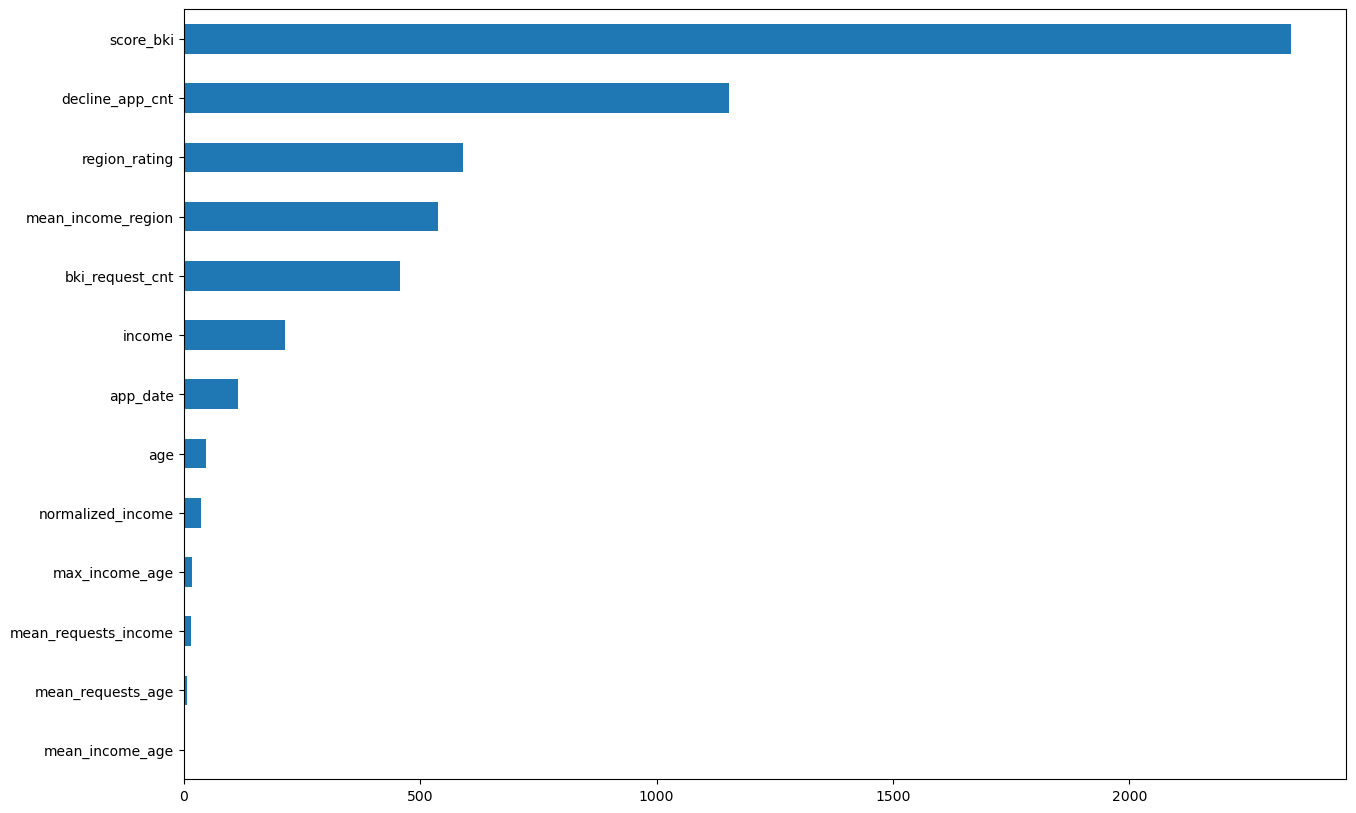

In [48]:
imp_num = pd.Series(f_classif(data_temp[num_cols], data_temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Новые признаки, к сожалению, не особо полезны

### Категориальные и бинарные

<AxesSubplot:>

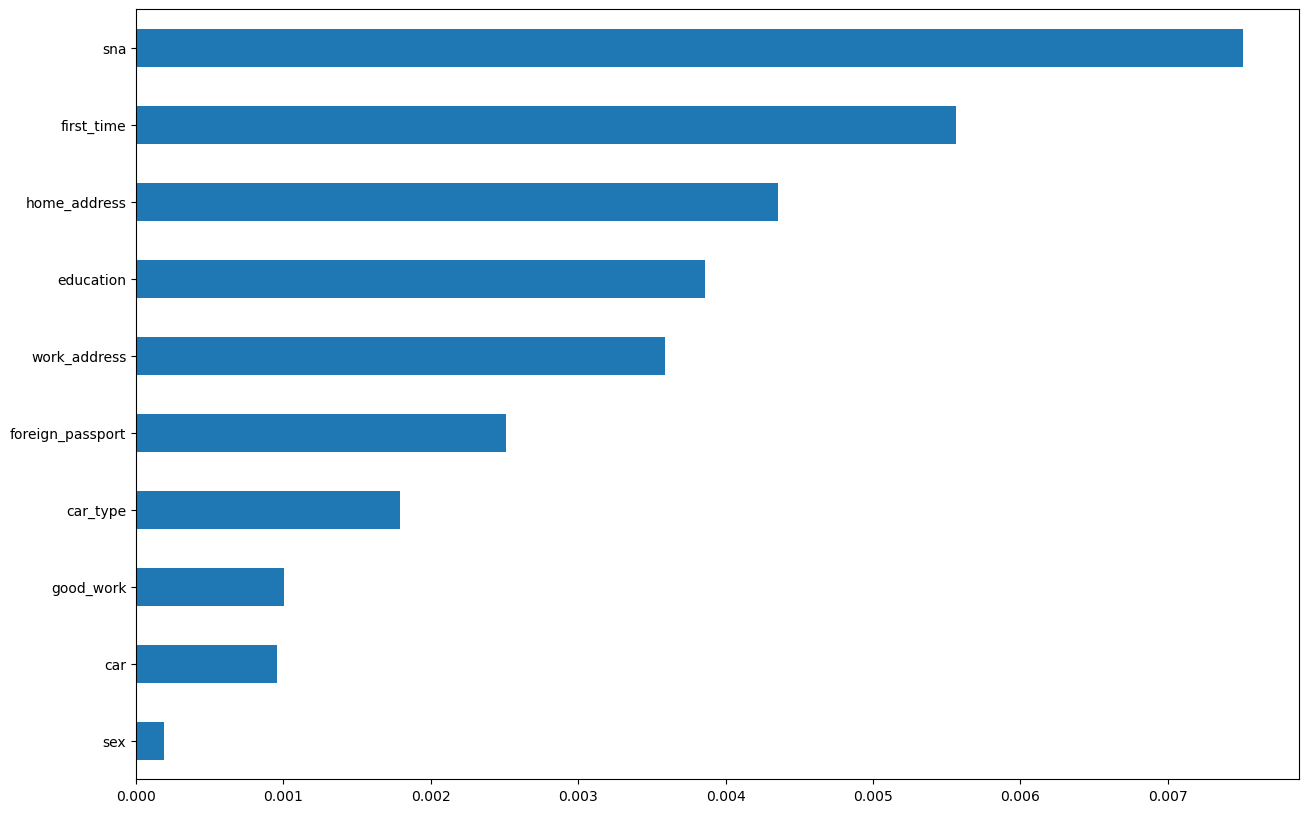

In [49]:
imp_cat = pd.Series(mutual_info_classif(data_temp[bin_cols + cat_cols], data_temp['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

## Encoding

In [50]:
df = pd.get_dummies(dataset, prefix=cat_cols, columns=cat_cols)

In [51]:
df = df.copy()

In [52]:
df.head(3)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address_1,home_address_2,sna_0,sna_1,sna_2,sna_3,first_time_0,first_time_1,first_time_2,first_time_3
0,25905,-0.934391,1,1.975219,1,1,-0.418815,0,-0.208688,-0.281790,...,0,0,0,0,0,1,1,0,0,0
1,63161,0.281474,0,1.714757,0,0,-0.418815,0,0.745419,0.770563,...,1,0,0,0,0,1,1,0,0,0
2,25887,-0.934391,1,-1.237142,1,0,2.621662,0,0.993988,-0.281790,...,0,0,1,0,0,0,0,0,0,1


# Сравнение моделей машинного обучения

In [53]:
train_df = df.query('sample == 1').drop(['sample','client_id'], axis=1)
test_df = df.query('sample == 0').drop(['sample','client_id'], axis=1)

In [54]:
X = train_df.drop(['default'], axis=1).values
y = train_df['default'].values 

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

accuracy_score: 0.781680216802168
precision_score: 0.19548598471059336
recall_score: 0.22802547770700637
f1_score: 0.21050568404547237
MSE:  0.218319783197832


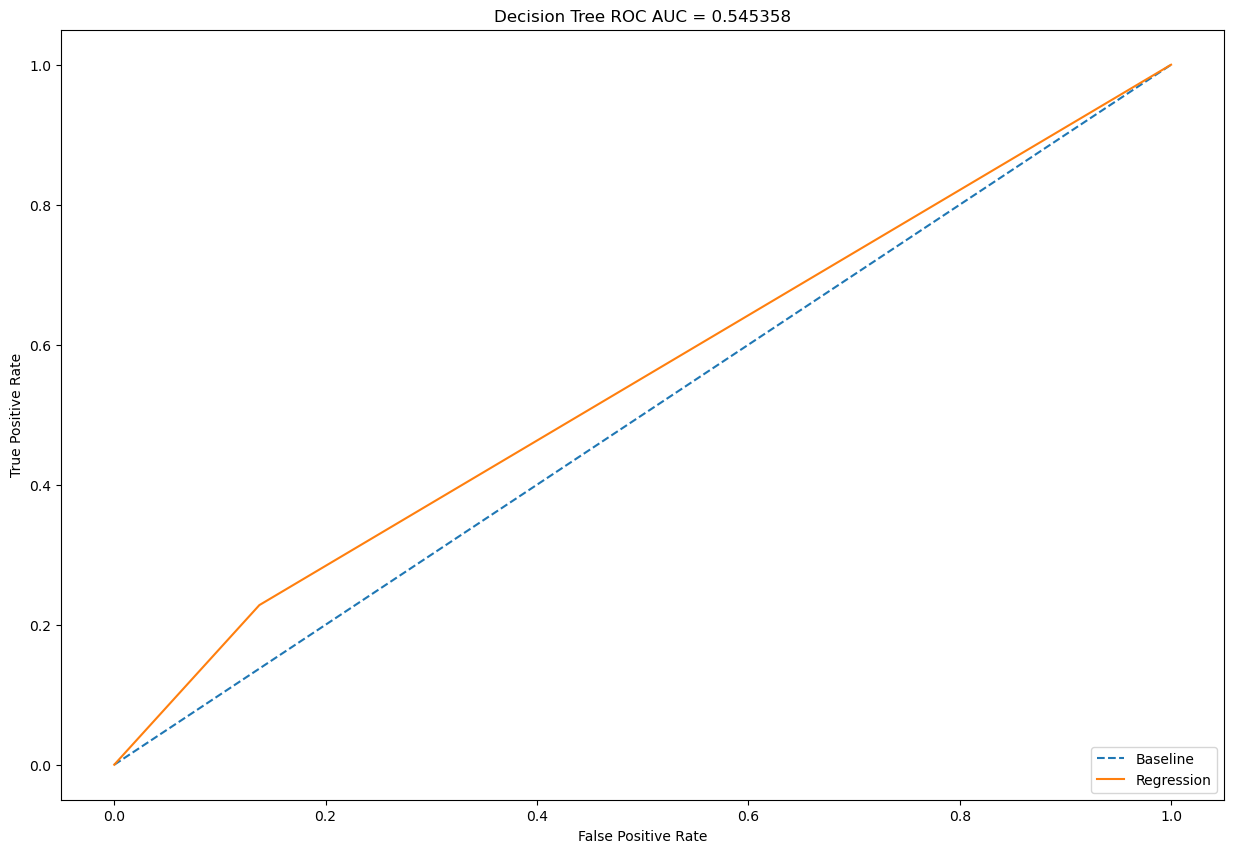

In [56]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

probs = dt_clf.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

print('accuracy_score:', accuracy_score(y_test, probs))
print('precision_score:', precision_score(y_test, probs))
print('recall_score:', recall_score(y_test, probs))
print('f1_score:', f1_score(y_test, probs))
print('MSE: ', mean_squared_error(y_test, probs))

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Decision Tree ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


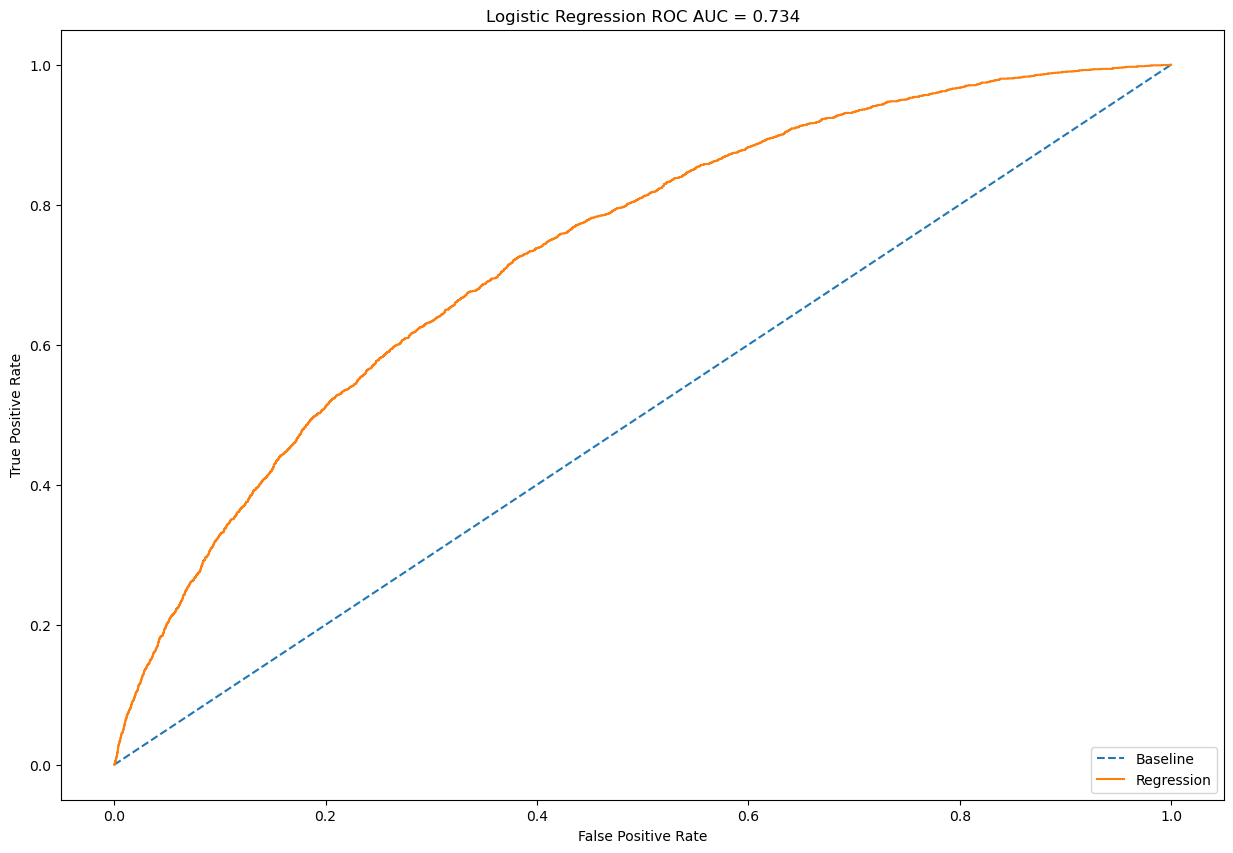

In [57]:
lr = LogisticRegression() 

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

probs = lr.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [58]:
print('accuracy_score:',accuracy_score(y_test,y_pred))
print('precision_score:',precision_score(y_test,y_pred))
print('recall_score:',recall_score(y_test,y_pred))
print('f1_score:',f1_score(y_test,y_pred))
print('MSE: ', mean_squared_error(y_test, probs))

accuracy_score: 0.8724661246612466
precision_score: 0.5079365079365079
recall_score: 0.027176220806794056
f1_score: 0.051592099959693674
MSE:  0.10209946677271023


Несмотря на высокий ROC AUC, F1 скор очень низкий

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

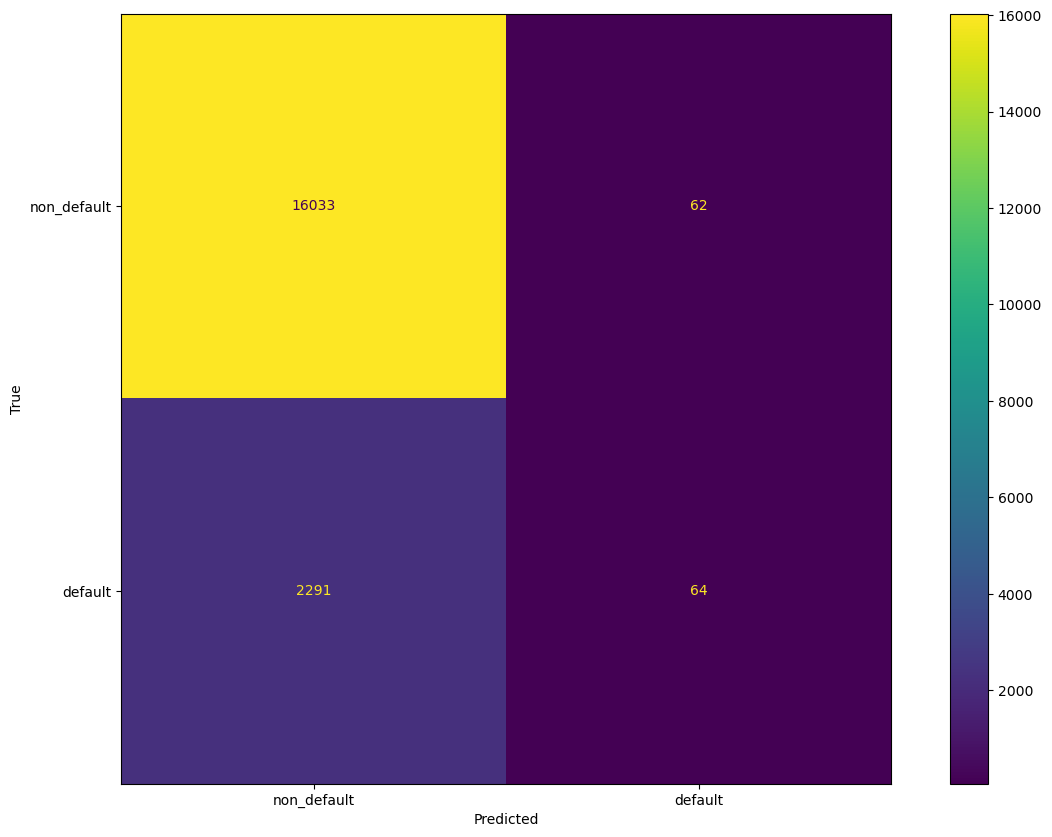

In [59]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default','default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

Модель в большинстве случаев предсказывает не дефолт, вероятно мы получаем хорошие показатели, так как в наших данных случаи дефолта редки.

0.7005420054200542
accuracy_score: 0.7005420054200542
precision_score: 0.1845143312101911
recall_score: 0.39363057324840767
f1_score: 0.2512535573926006
MSE: 0.2995


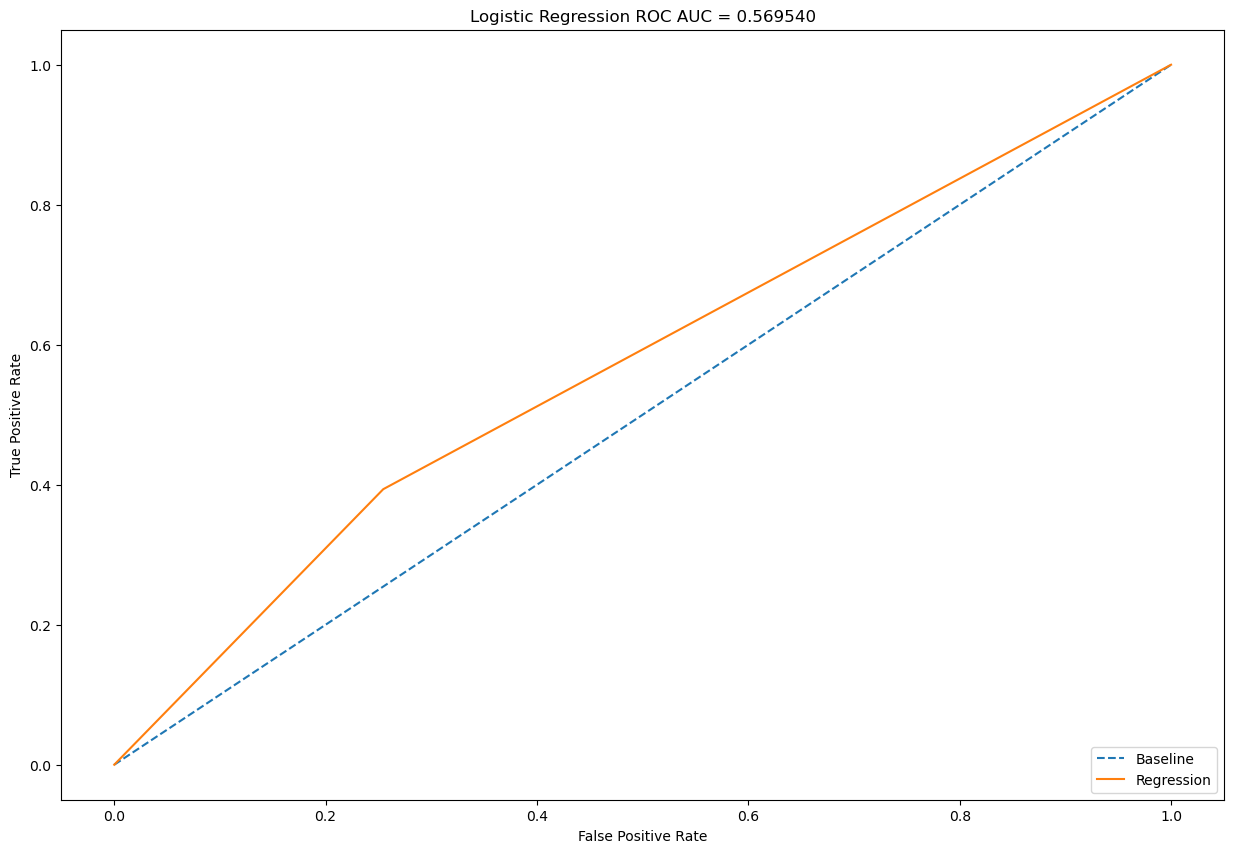

In [60]:
nn = linear_model.Perceptron()
nn.fit(X_train, y_train)

probs = nn.predict(X_test)

print(nn.score(X_test, y_test))

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
print('accuracy_score:', accuracy_score(y_test, probs))
print('precision_score:', precision_score(y_test, probs))
print('recall_score:', recall_score(y_test, probs))
print('f1_score:', f1_score(y_test, probs))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, probs), 4)))

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Подбор гиперпараметров и кросс валилдация

### XGB with GridsearchCV

In [61]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [62]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [63]:
folds = 4
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, 
                                   scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

random_search.fit(X_train, y_train)


Fitting 4 folds for each of 5 candidates, totalling 20 fits
[16:36:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.



RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000000000EBD8A50>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                              

In [64]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([19.96142381, 33.12084943, 29.32631713, 21.69261003, 27.91938055]), 'std_fit_time': array([0.45413374, 0.1533423 , 0.05630234, 0.11323618, 0.09473291]), 'mean_score_time': array([0.0823254 , 0.14438093, 0.1411283 , 0.16189718, 0.10509539]), 'std_score_time': array([0.00327214, 0.00204829, 0.00360856, 0.00630583, 0.00495386]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
         

accuracy_score: 0.8723035230352304
precision_score: 0.4948453608247423
recall_score: 0.02038216560509554
f1_score: 0.03915171288743882


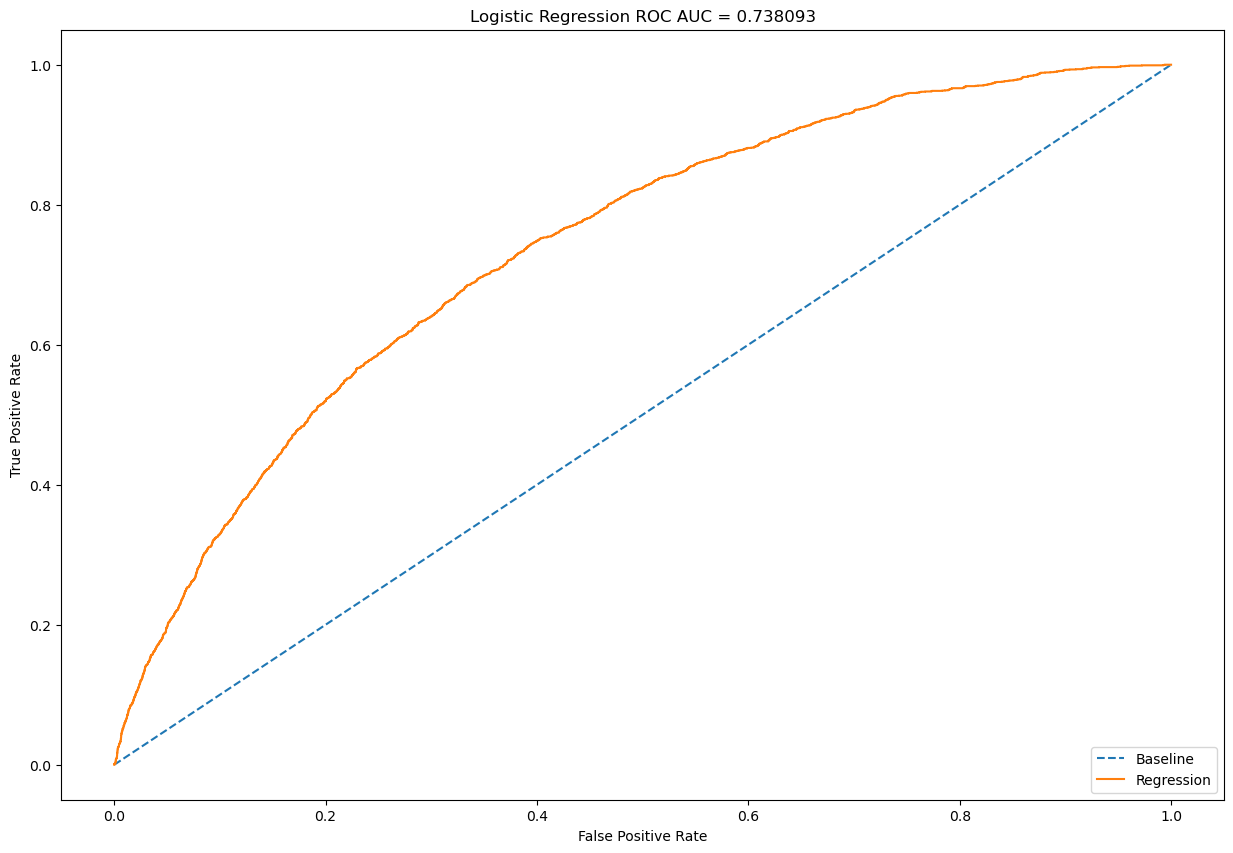

In [65]:
y_pred = random_search.predict(X_test)
probs = random_search.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

print('accuracy_score:',accuracy_score(y_test,y_pred))
print('precision_score:',precision_score(y_test,y_pred))
print('recall_score:',recall_score(y_test,y_pred))
print('f1_score:',f1_score(y_test,y_pred))

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()